# Current Issue
In our private preserving data muling network, timing patterns matter because they reveal information about the mobility patterns of a mule. One solution we've implemented is uploading in set batches at a set rate. Batching and set frequency uploads are ideal from a privacy perspective because the server is unable to distinguish between upload patterns of two differnt mules. This gives the strongest possible privacy gaurentee. However, the problem that we have with batching and set frequency uploads is that it uploads way too much data. In short, the goodput is terrible. 

# Solution

Instead of using completely indistinguishable upload patterns, perhaps there is an intelligent way we can delay uploads so that the attacker server still does not gain any useful information. Our idea for this is to use trickle uploads which slowly upload all the data in the mule storage at once as soon as possible (within wifi range). This method, however, still leaks some information about how recently a mule passed a sensor. To hide this we can use delays with some randomness generated using differential privacy.   


In [6]:
# Import libraries.
import csv
import numpy as np
import pandas as pd
from matplotlib import cm
from matplotlib import pyplot as plt

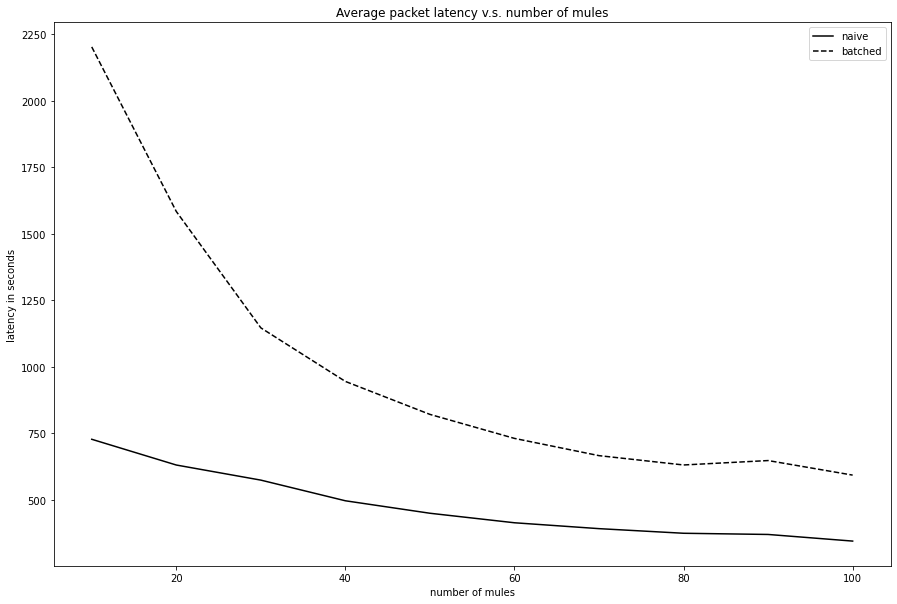

In [17]:
# generate a plot for how average latency changes over number of mules
# Copied from Alvin's latency_and_throughput_per_packet.ipynb
num_mules_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] # integer <= 100
naive_latencies = []
batch_latencies = []
dp_latencies = []
random_latencies = []
schedule_file = '../probabilistic_routing/prob_data/random_uploads/vary_mules/{}_mule_schedule.csv'

#Differential Privacy variables
sensitivity = 1
epsilon = 0.1
delay_mean = 60*30 #in seconds, so 30mins after 

# add random response noise and laplace noise to delay
def add_noise(latency): 
    if np.random.randint(0,2) == 0:
        return latency
    else:
        #toss a coin to decide if you upload or delay
        if np.random.randint(0,2) == 0:
            return latency
        else:
            #add delay with laplace noise
            return latency + np.random.laplace(loc=delay_mean, scale=sensitivity/epsilon)
        
def add_noise_fun_times(latency):
    #pick a totally random delay (1 - 24hrs?)
    delay_mean_rand = np.random.randint(60*30,24*60*60) #30min to 24hrs
    if np.random.randint(0,2) == 0:
        return latency
    else:
        #toss a coin to decide if you upload or delay
        if np.random.randint(0,2) == 0:
            return latency
        else:
            #add delay with laplace noise
            return latency + np.random.laplace(loc=delay_mean_rand, scale=sensitivity/epsilon)    

for index, num_mules in enumerate(num_mules_list):
    schedule_df = pd.read_csv(schedule_file.format(num_mules), skiprows=3)
    schedule_df['naive_latency'] = schedule_df['pickup_time'] - schedule_df['sample_time']
    schedule_df['batch_latency'] = schedule_df['batch_time'] - schedule_df['sample_time']
    schedule_df['dp_latency'] = schedule_df['pickup_time'] - schedule_df['sample_time'] + np.random.laplace(loc=delay_mean, scale=sensitivity/epsilon)
    schedule_df['random_response_latency'] = schedule_df['naive_latency'].apply(add_noise)
    schedule_df['random_response_test'] = schedule_df['naive_latency'].apply(add_noise_fun_times)
    naive_latencies.append(schedule_df['naive_latency'].mean())
    batch_latencies.append(schedule_df['batch_latency'].mean())
    dp_latencies.append(schedule_df['dp_latency'].mean()) 
    random_latencies.append(schedule_df['random_response_latency'].mean())

plt.figure(figsize=(15,10))
plt.plot(num_mules_list, naive_latencies, 'k-', label='naive')
plt.plot(num_mules_list, batch_latencies, 'k--', label='batched')
#plt.plot(num_mules_list, dp_latencies, 'k--',label = 'dp')
plt.legend()
plt.title('Average packet latency v.s. number of mules')
plt.ylabel('latency in seconds')
plt.xlabel('number of mules')
plt.show()

## Differential Privacy Background
### (Adapted from UW ECE595 Lab 3)

*Differential privacy* is a formal notion of privacy. Differential privacy is a property of *algorithms*, and not a property of *data*. That is, we can prove that an *algorithm* satisfies differential privacy; to show that a *dataset* satisfies differential privacy, we must show that the algorithm which produced it satisfies differential privacy.

A function which satisfies differential privacy is often called a *mechanism*. We say that a *mechanism* $F$ satisfies differential privacy if for all *neighboring datasets* $x$ and $x'$, and all possible outputs $S$,

\begin{align}
\frac{\mathsf{Pr}[F(x) = S]}{\mathsf{Pr}[F(x') = S]} \leq e^\epsilon
\end{align}

The $\epsilon$ parameter in the definition is called the *privacy parameter* or the *privacy budget*. $\epsilon$ provides a knob to tune the "amount of privacy" the definition provides. Small values of $\epsilon$ require $F$ to provide *very* similar outputs when given similar inputs, and therefore provide higher levels of privacy; large values of $\epsilon$ allow less similarity in the outputs, and therefore provide less privacy. 

The general consensus is that $\epsilon$ should be around 1 or smaller, and values of $\epsilon$ above 10 probably don't do much to protect privacy - but this rule of thumb could turn out to be very conservative. 

According to the Laplace mechanism, for a function $f(x)$ which returns a number, the following definition of $F(x)$ satisfies $\epsilon$-differential privacy:

\begin{align}
F(x) = f(x) + \textsf{Lap}(\frac{s}{\epsilon})
\end{align}

where $s$ is the *sensitivity* of $f$, and $\textsf{Lap}(S)$ denotes sampling from the Laplace distribution with center 0 and scale $S$.

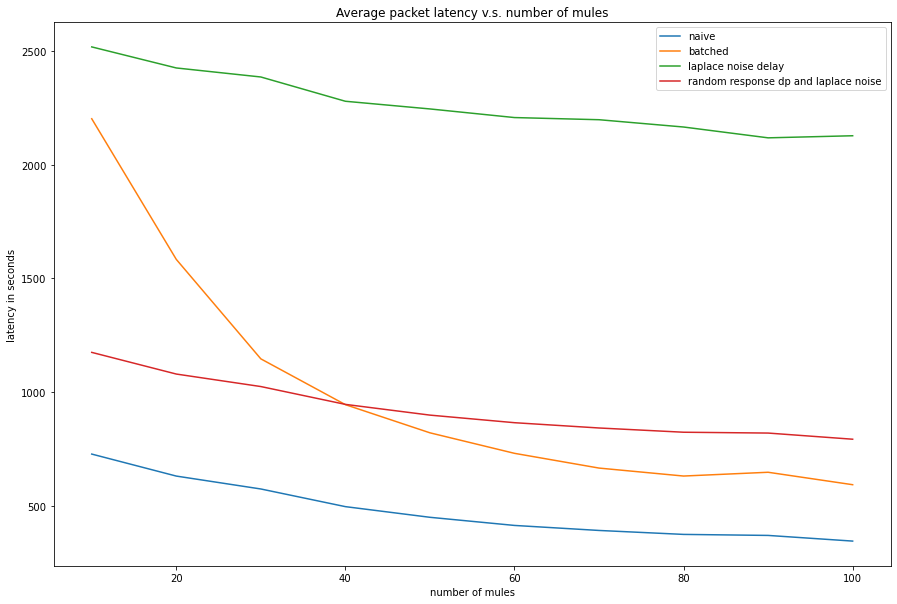

In [18]:
plt.figure(figsize=(15,10))
plt.plot(num_mules_list, naive_latencies, label='naive')
plt.plot(num_mules_list, batch_latencies, label='batched')
plt.plot(num_mules_list, dp_latencies,label = 'laplace noise delay')
plt.plot(num_mules_list, random_latencies,label = 'random response dp and laplace noise')
plt.legend()
plt.title('Average packet latency v.s. number of mules')
plt.ylabel('latency in seconds')
plt.xlabel('number of mules')
plt.show()

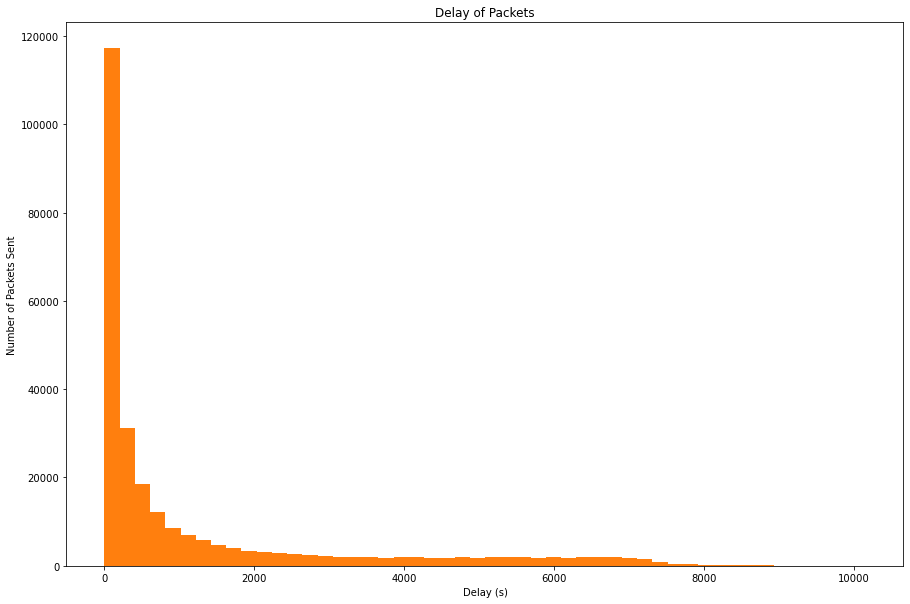

In [20]:
def add_noise_fun_times(latency):
    #pick a totally random delay (1 - 24hrs?)
    delay_mean_rand = np.random.randint(60,2*60*60) #1min to 24hrs
    if np.random.randint(0,2) == 0:
        return latency
    else:
        #toss a coin to decide if you upload or delay
        if np.random.randint(0,2) == 0:
            return latency
        else:
            #add delay with laplace noise
            return latency + np.random.laplace(loc=delay_mean_rand, scale=sensitivity/epsilon) 

#mule upload schedule for mules network as example n = 10 
num_mules = 100
schedule_df = pd.read_csv(schedule_file.format(num_mules), skiprows=3)

#sort by mule_id 
schedule_df.sort_values(by='mule_id')
schedule_df['naive_latency'] = schedule_df['pickup_time'] - schedule_df['sample_time']
schedule_df['random_response_latency'] = schedule_df['naive_latency'].apply(add_noise)
schedule_df['random_response_test'] = schedule_df['naive_latency'].apply(add_noise_fun_times)

#print(schedule_df.head())
#print(schedule_df['mule_id'].unique().shape)
plt.figure(figsize=(15,10))
#plt.hist(schedule_df['random_response_latency'], bins=50, label='random_response_latency') 
plt.hist(schedule_df['naive_latency'], bins = 50, label='naive_latency') 
plt.hist(schedule_df['random_response_test'],bins = 50, label = 'fun_latency')
plt.xlabel("Delay (s)")
plt.ylabel("Number of Packets Sent")
plt.title("Delay of Packets")
plt.show()

#print(schedule_df['random_response_latency'].mean())
#print(schedule_df['naive_latency'].mean())


# Current Challenges

The dp experiment adds laplace noise to every delay. This isn't really differentially private because we don't have the full set of each mules data. Do we want to add more noise for networks with fewer mules because it's easier to identify a single mule out of all the mules if the pool is smaller? Yes, therefore, an issue is that we'd like to give a mule the same privacy it would have it it were not participating in the network, but we can only add noise locally. Therefore we must use local differential privacy (RAPPOR and DP-Crypt as references).

Another issue is that on the server side they could in theory gain repeated information about someones routine. Could these repeated sets of information eventually reveal the true timing? Yes, if the server knew it was the same sensor each time given enough queries the true time delay would remain. 

1) Basic Randomized Response 
Ask do I upload today? 
-flip coin:
if heads, upload, if tails flip again then upload if heads, don't upload if tails
-this can be tunable to change the probabilities 
-pick a random time to upload if upload was selected 

2) Less private randomized response
Ask do I delay my upload?
same thing but just upload immediately 
This could be made more robust with some cover traffic. Users could pay for this additional privacy shield if they want it. 
epsilon = ln(3)

Current issue is that with repeated queries or knowledge about repeat patterns this breaks down. We can't use RAPPORs bloom filter method because we also don't know if it's repeated information.

A solution: Cover traffic? 

If we add cover traffic randomly as a function of how much data the mule is uploading, so for every 5th upload we add cover traffic? 

In [4]:
# Adding cover traffic to add privacy to randomized response

schedule_df.head


<bound method NDFrame.head of         sensor_id  mule_id  sample_time  pickup_time  batch_time  data_length  \
0             697        0          0.0     1.501024         557          128   
1             977        0          0.0     1.501024         557          128   
2             624        0          0.0     3.501024         557          128   
3             638        0          0.0     7.501024         557          128   
4              17        0         20.0    20.001024         557          128   
...           ...      ...          ...          ...         ...          ...   
267462        329       99       3540.0  3568.286016        5184          128   
267463        329       99       3550.0  3568.287040        5184          128   
267464        329       99       3560.0  3568.288064        5184          128   
267465        329       99       3570.0  3570.001024        5184          128   
267466        602       99       3570.0  3578.101024        5184          128  

In [ ]:
# A trickle upload